In [6]:
import pandas as pd

all_postings = pd.read_csv('processed_description.csv')


### Split validation, training and test set

In [7]:
# define target class and input text
target = all_postings['salary_bin'].astype('category')
text = all_postings['processed_description']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# split data into 70% training, 10% validation and 20% testing set
tfidf = TfidfVectorizer().fit(text)
X_tfidf =  tfidf.transform(text)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, target, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)


### TF-IDF Vectorization

In [9]:
# map salary bin to range
salary_info = {all_postings.salary_bin.unique()[i]: all_postings.salary_range.unique()[i] for i in range(len(all_postings.salary_bin.unique()))}
print(salary_info)

{1: '50k-100k', 0: '0-50k', 3: '150k+', 2: '100k-150k'}


## ML Models 
### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, f1_score
import numpy as np


# tune the hyperparameter C using the validation set
C_values = [0.01, 0.1, 1, 10, 100]
val_accuracy = []
for C in C_values:
    logistic_regression = LogisticRegression(C=C, max_iter=1000, penalty='l2',multi_class='ovr')
    logistic_regression.fit(X_val, y_val)
    
    y_val_pred = logistic_regression.predict(X_val)
    val_accuracy.append(accuracy_score(y_val, y_val_pred))

best_C = C_values[np.argmax(val_accuracy)]

# fit the model on the training set using the best C
logistic_regression = LogisticRegression(C=C, max_iter=1000, penalty='l2',  multi_class='ovr')
logistic_regression.fit(X_train, y_train)


# evaluate the model on the test set
y_test_pred = logistic_regression.predict(X_test)
y_test_pred_proba = logistic_regression.predict_proba(X_test)

logreg_accuracy = accuracy_score(y_test, y_test_pred)
logreg_f1 = f1_score(y_test, y_test_pred, average='weighted')
logreg_auc = roc_auc_score(y_test, y_test_pred_proba, average='weighted', multi_class='ovr')
print(f'Logistic Regression Accuracy: {logreg_accuracy}')
print(f'Logistic Regression F1 Score: {logreg_f1}')
print(f'Logistic Regression AUC Score: {logreg_auc}')



### SVM

In [6]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score

class_weight = dict(all_postings['salary_bin'].value_counts(normalize=True))
# tune the hyperparameter C using the validation set
C_values = [0.01, 0.1, 1, 10, 100]
val_accuracy = []
for C in C_values:
    svm = LinearSVC(C=C, max_iter=10000, class_weight=class_weight, multi_class='ovr')
    svm.fit(X_val, y_val)
    
    y_val_pred = svm.predict(X_val)
    val_accuracy.append(accuracy_score(y_val, y_val_pred))

best_C = C_values[np.argmax(val_accuracy)]

# fit the model on the training set using the best C
svm = LinearSVC(C=best_C, max_iter=10000, class_weight=class_weight)
svm.fit(X_train, y_train)

# evaluate the model on the test set
y_test_pred = svm.predict(X_test)


svm_f1 = f1_score(y_test, y_test_pred, average='weighted')
svm_auc = roc_auc_score(y_test, y_test_pred_proba, average='weighted', multi_class='ovr')

print(f'Linear SVC Accuracy: {accuracy_score(y_test, y_test_pred)}')
print(f'Linear SVC F1 Score: {svm_f1}')
print(f'Linear SVC AUC Score: {svm_auc}')



/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/a

Linear SVC Accuracy: 0.6857677902621723
Linear SVC F1 Score: 0.6844037636748125
Linear SVC AUC Score: 0.8738697799700356


### Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
clf = RandomForestClassifier(n_estimators=1000, max_depth=50, bootstrap=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
print('AUC Score: ', roc_auc_score(y_test, clf.predict_proba(X_test), average='weighted', multi_class='ovr'))





Accuracy:  0.6438202247191012
F1 Score:  0.6265113110902327
AUC Score:  0.8732683344285769


### XGBoost


In [8]:

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.1)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
print('AUC Score: ', roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr'))


Accuracy:  0.7389513108614232
F1 Score:  0.7364602702541417
AUC Score:  0.909211247281954


### Feedforward Neural Network

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

mlp = MLPClassifier(hidden_layer_sizes=4, max_iter=1000)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
print('AUC Score: ', roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr'))



Accuracy:  0.6812734082397004
F1 Score:  0.6821028524689037
AUC Score:  0.8708922334866004


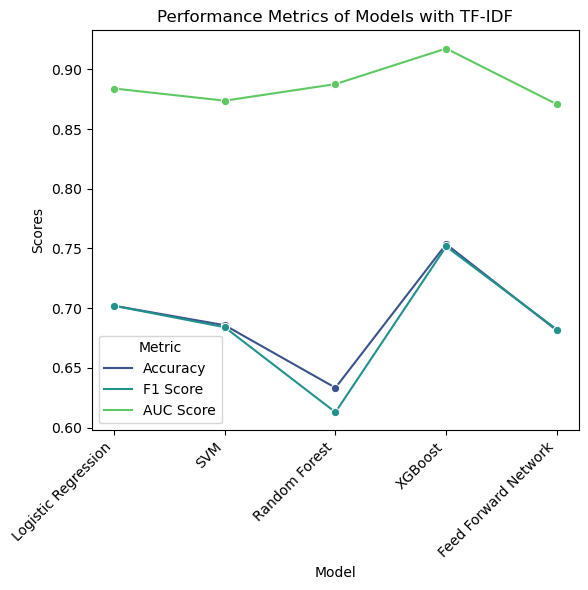

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Models
models = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost', 'Feed Forward Network']
accuracy = [0.702, 0.6857, 0.6333, 0.7536, 0.6813]
f1_score = [0.702, 0.684, 0.6128, 0.7517, 0.6821]
auc_score = [0.884,0.8738, 0.8877, 0.9175, 0.8708]

# Create a DataFrame for the data
data = pd.DataFrame({'Model': models*3,
                     'Metric': ['Accuracy']*5 + ['F1 Score']*5 + ['AUC Score']*5,
                     'Score': accuracy + f1_score + auc_score})

# Plot using Seaborn
plt.figure(figsize=(6,6))
sns.lineplot(x='Model', y='Score', hue='Metric', marker='o', data=data, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Performance Metrics of Models with TF-IDF')
plt.ylabel('Scores')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()



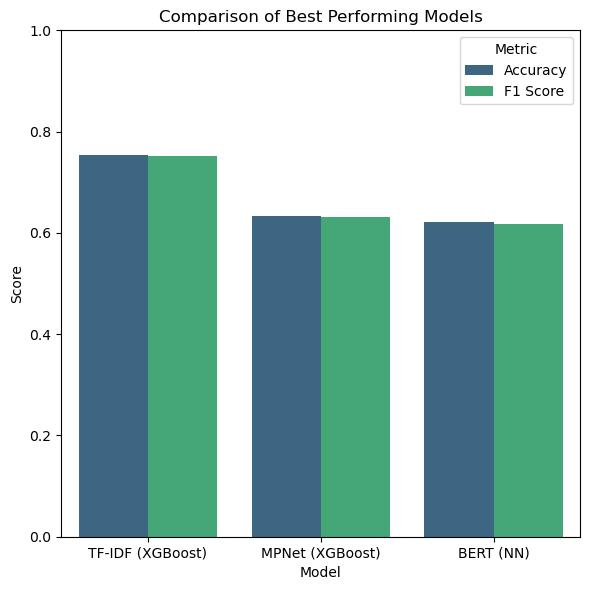

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Models
models = ['TF-IDF (XGBoost)', 'MPNet (XGBoost)', 'BERT (NN)']
accuracy_scores = [0.7536, 0.6333, 0.6221]  
f1_scores = [0.7517, 0.6307, 0.6172]  

# Create a DataFrame for the data
import pandas as pd
data = pd.DataFrame({'Model': models*2,
                     'Metric': ['Accuracy']*3 + ['F1 Score']*3,
                     'Score': accuracy_scores + f1_scores})

# Plot using Seaborn
plt.figure(figsize=(6, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=data, palette='viridis')
plt.ylim(0, 1)
plt.title('Comparison of Best Performing Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()
